# maplib demo
_Connected Data London 2025_

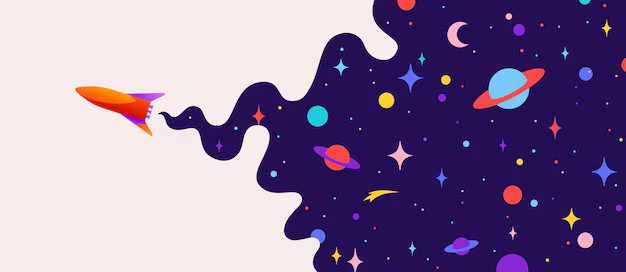

### Agenda
- Motivation and introduction
- Data frames
- Ontology
- OTTR and mapping
- Datalog reasoning
- Graph explorer
- SHACL

In [ ]:
import polars as pl
pl.Config.set_fmt_str_lengths(150)

## Data frames

maplib use [Polars](https://pola.rs/) data frames for handling instance data. 

Data sources used in this demo: [planets.csv](https://github.com/devstronomy/nasa-data-scraper/tree/master) [satellites.csv](https://github.com/devstronomy/nasa-data-scraper/tree/master) [stars.csv](https://www.kaggle.com/datasets/waqi786/stars-dataset/data)


In [ ]:
df_planets = pl.read_csv("../data/planets.csv")

In [ ]:
# Having a look at what data we have to play with
print(df_planets.columns)

In [ ]:
# Look at the content in column "planet". Can we use this information as our global unique identifier for planet?
print(df_planets["planet"])

In [ ]:
# Probably yes, for this case. But we need to create a planet URI to use as subject
df_planets = df_planets.with_columns( 
    (pl.lit("http://data.treehouse.example/") + pl.col("planet")).alias("planet_uri")
)

In [ ]:
print(df_planets.columns)

In [ ]:
# Let's select a few columns to work with
df_planets = df_planets.select(
    ["planet", "planet_uri", "mean_temperature", "length_of_day", "orbital_period"]
)

## Mapping

**maplib** use [Reasonable Ontology Templates](https://ottr.xyz/) (OTTR) for serialising instance data stored in data frames to RDF.

OTTR provides a syntax for creating templates, called stOTTR, and is a bit similar to RDF Turtle, but not quite. 

```
@prefix : <http://data.treehouse.example/> .
@prefix tpl: <http://data.treehouse.example/tpl/> .
@prefix ottr: <http://ns.ottr.xyz/0.4/> .
@prefix rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .


tpl:Planet[ 
    ! ottr:IRI ?planet_uri,
    xsd:string ?planet,
    ?mean_temperature,
    ?length_of_day,
    ?orbital_period
 ] :: {
    ottr:Triple(?planet_uri, rdf:type, :Planet), 
    ottr:Triple(?planet_uri, rdf:type, owl:NamedIndividual),
    ottr:Triple(?planet_uri, rdfs:label, ?planet),
    ottr:Triple(?planet_uri, :memberOf, :SolarSystem),
    ottr:Triple(?planet_uri, :meanTemperature, ?mean_temperature),
    ottr:Triple(?planet_uri, :lengthOfDay, ?length_of_day),
    ottr:Triple(?planet_uri, :orbitalPeriod, ?orbital_period)
} .
```

1. First, we define all the prefixes we need.
2. Then we create the template signature `tpl:Planet[ ... ]`
   * Moderators `!` for mandatory and `?` for optional.
   * Typesetting `ottr:IRI` and `xsd:string` etc, where data type is known.
   * Name of variable as `?planet_uri` **must** correspond to data frame column header.
3. Instructions for serialisation given in body `:: { ... } .`.
   * maplib currently supports `ottr:Triple(?s, ?p, ?o)` and reusage of custom templates within the same file, it is on the roadmap to support the rest of tpl.ottr.xyz.

If you need a kickstart to building templates, you can simply use the function `m.expand_default(subject, df)` to generate a template based on your data frame. ♥

If you need more information about OTTR, have a look at the author's [OTTR Masterclass](https://github.com/veleda/ottr-masterclass).

In [ ]:
from maplib import Model

# Serialise data frame content to RDF using OTTR template
with open("../tpl/tpl-planets.ttl", "r") as file:
    tpl = file.read()
m = Model()
m.add_template(tpl)

m.map("http://data.treehouse.example/tpl/Planet", df_planets)

In [ ]:
count = """
    SELECT (COUNT(?s) AS ?count)
    WHERE { ?s ?p ?o . }
"""

In [ ]:
# Count number of triples serialised from planet
m.query(count)